In [1]:
import numpy as np
from graspologic.plot import heatmap
import igraph
import matplotlib.pyplot as plt
import random
from graspologic.match import GraphMatch as GMP
from graspologic.utils import pass_to_ranks
from scipy.stats import rankdata
import pyreadr
!ls

HSfbgraphcore.txt       VN_via_SGM_2.ipynb      VN_via_SGM_6.ipynb
HSfrgraphcore.txt       VN_via_SGM_3.ipynb      ego.py
VNSGM_function_v3.ipynb VN_via_SGM_4.ipynb      ego_testing.ipynb
VN_via_SGM.ipynb        VN_via_SGM_5.ipynb      fig6_data.npy


# Helper Functions

In [99]:
def permute_adj_matrix(adj_mat):
    assert adj_mat.shape[0] == adj_mat.shape[1]
    indexs = np.random.permutation(np.arange(adj_mat.shape[0]))
    ress = np.zeros(adj_mat.shape)
    for ii, ind in enumerate(indexs):
        ress[ii] = adj_mat[ind][indexs]
    return ress, indexs

def ego(graph_adj_matrix, order, node, mindist=1):
    #Note all nodes are zero based in this implementation, i.e the first node is 0
    dists = [[node]]
    for ii in range(1, order+1):
        clst = []
        for nn in dists[-1]:
            clst.extend(list(np.where(graph_adj_matrix[nn]==1)[0]))
        clst = list(set(clst))
        
        #Remove all the ones that are closer (i.e thtat have already been included)
        dists_conglom = []
        for dd in dists:
            dists_conglom.extend(dd)
        dists_conglom = list(set(dists_conglom))
        
        cn_proc = []
        for cn in clst:
            if cn not in dists_conglom:
                cn_proc.append(cn)
        
        dists.append(cn_proc)
    ress = []
        
    for ii in range(mindist, order+1):
        ress.extend(dists[ii])
        
    return list(set(ress))  

def ego_list(graph_adj_matrix, order, node, mindist=1):
    print(type(node))
    if type(node) == list:
        total_res = []
        for nn in node:
            ego_res = ego(graph_adj_matrix, order, nn, mindist=1)
            total_res.extend(ego_res)
        return list(set(total_res))
    else:
        return ego(graph_adj_matrix, order, node)

def shuffle_adj_matrix(adj_mat, shuffle_lst):
    assert adj_mat.shape[0] == adj_mat.shape[1]
    ress = np.zeros((len(shuffle_lst), len(shuffle_lst)))
    for ii, ind in enumerate(shuffle_lst):
        ress[ii] = adj_mat[ind][shuffle_lst]
    return ress

def pass2ranksuplus(matt):
    out_matt = np.zeros(matt.shape)
    for rr in range(matt.shape[0]):
        out_matt[rr] = rankdata(matt[rr])
    return out_matt


# Implementation of VN via SGM algorithm

In [260]:
def vnsgm(x, seeds, A, B, h, ell, R, g, pad=0, sim=False, verb=False, plotF=False):
    '''
    Parameters
    ----------
    
    x: int or ndarray
        verticies of interest (voi)
    
    seeds: ndarray
        seeds vector
        
    A: ndarray
        Adjacency matrix of `G_1`, the graph where voi is known
        
    B: ndarray
        Adjacency matrix of `G_2`, the graph where voi is not known
        
    h: int
        distance between voi used to create induced subgraph on `G_1`
        
    ell: int 
        distance from seeds to other verts to create induced subgraphs on `G_1`
        
    R: int 
        number of restarts
    
    g: float
        gamma to be used, max tol for alpha, tollerable dist from barycenter
        
    
    
    '''
    
    nv1 = A.shape[0]
    nv2 = A.shape[0]
    
    nv = max(nv1, nv2)
    
    nsx1 = set(range(nv1)).difference(set([seeds[0], x]))
    
    vec = [seeds[0], x]; vec.extend(nsx1)
    
    AA = shuffle_adj_matrix(A, vec)
#     print(AA[:, -10:])


    ns2 = set(range(nv2)).difference(set([seeds[1]])) # <- setdiff(1:nv2,seeds[,2])
    vec2 = [seeds[1]]; vec2.extend(ns2) # <- c(seeds[,2],ns2)
    
#     print(B[:, -10:])

    BB = shuffle_adj_matrix(B, vec2)
#     print(BB[:, -10:])

    nrow_seeds = seeds.shape[0]

    S = list(range(nrow_seeds))
    
    voi = list(range(nrow_seeds, nrow_seeds+2))
    
    #print("inside 1 w/ shapes ", AA.shape, BB.shape)
    
    P = vnsgm_ordered(voi,S,AA,BB,h,ell,R,g,pad=pad,sim=sim,verb=verb,plotF=plotF)
    
    P['x'] = x
    P['S'] = seeds
#     print(seeds, P['Sx'],P['Sxp'])
#     P['Sx']  = seeds[P['Sx'],0]
#     P['Sxp'] = seeds[P['Sxp'],1]
#     print('vec2 = ', vec2)
#     print('vec = ', vec)
#     print('Cxp = ', P['Cxp'])
#     print('labelsGx = ', P['labelsGx'])
    
    if P['Cxp'] is not None:   
        foo = []
        for kk in P['Cxp']:
            foo.append(vec2[kk])
        P['Cxp'] = foo
        
    if P['labelsGx'] is not None:
        foo = []
        for kk in P['labelsGx']:
            foo.append(vec[kk])
        P['labelsGx'] = foo
    
    if P['labelsGxp'] is not None:
        foo = []
        for kk in P['labelsGxp']:
            foo.append(vec2[kk])
        P['labelsGxp'] = foo 
    return P

def vnsgm_ordered(x,S,A,B,h,ell,R,g,pad=0,sim=True,verb=False,plotF=False):
    '''
    Parameters
    ----------
    
    x: list 
        Verticies of intrerest
        
    S: list
        Vector of seeds
        
    A: ndarray
        `G_1` where voi are known
    
    B: ndarray
        `G_2` where voi unknown
        
    rest same as before
    '''
    s = len(S)
    Nh = ego_list(A, h, x, mindist=1) # TODO: make able to take a list in <- unlist(ego(g1,h,nodes=x,mindist=1))
    
    Sx1 = None; Sx2 = None
    
    Sx1 = list(set(Nh).intersection(set(S))); Sx1.sort(); sx = len(Sx1)
    
    Sx2 = list(set(list(range(B.shape[0]))).intersection(set(Sx1))); Sx2.sort(); sx2 = len(Sx2)
    #print("SX1, Sx2, ", Sx1, Sx2)
               
    case = 'possible' if sx2>0 else 'impossible'
    
    if case == 'possible':
        Cx2 = ego_list(B, ell, Sx2, mindist=1)
        Cx2 = set(Cx2).difference(set(Sx2))
        print(Cx2)
        if sim:
            case = np.array(['possible' if _x in Cx2 else 'impossible' for _x in x])
            
        
        if len(np.where(case == 'possible')[0])>0:
            Nx1 = ego_list(A, ell, Sx1, mindist=0)
            Nx2 = ego_list(B, ell, Sx2, mindist=0)
            
            #print("NX1, Nx2, ",len(Nx1), len(Nx2), Nx1, Nx2)
            
            if sim:
                #print("in opt 1")
                wxp = np.where(case == 'possible')[0]
                print(wxp)
                xp = x#x[wxp]
                
                print(Sx1, x, Nx1, np.setdiff1d(Nx1, np.concatenate((Sx1, x))))
                ind1 = np.concatenate((Sx1, x, np.setdiff1d(Nx1, np.concatenate((Sx1, x)))))
                print(Sx2, xp, Nx2)#, np.setdiff1d(Nx2, np.concatenate((Sx2, xp))))


                ind2 = np.concatenate((Sx2, xp, np.setdiff1d(Nx2, np.concatenate((Sx2, xp)))))
            else:
                #print("in opt 2")
                ind1 = Sx1 + x + list(set(Nx1).difference(set(Sx1+x)))
                
                ind2 = Sx2 + list(set(Nx2).difference(set(Sx2)))
                
            if verb:
                print("seed = ", Sx1, ", matching ", ind1, " and ", ind2)
                
            #print("inside 2 w/ params Sx1 = ", Sx1, ", x = ", x, ", Nx1 = ", Nx1)
            #print("inside 2 w/ indlens ", len(ind1), len(ind2), ind1, ind2)
            n_iters = 20
            As = shuffle_adj_matrix(A, ind1)
            Bs = shuffle_adj_matrix(B, ind2)
            
            sgm = GMP(n_init=n_iters)
            
            # Note we must padd because the inputs are note guarenteed to be the same
            totv1 = As.shape[1]
            totv2 = Bs.shape[1]

            if (totv1>totv2):
                #print("in pad 2")
                diff = totv1-totv2
                Bs = np.concatenate((Bs, np.full((Bs.shape[0], diff), pad)), axis=1)
                Bs = np.concatenate((Bs, np.full((diff, Bs.shape[1]), pad)), axis=0)
            elif (totv1<totv2):
                #print("in pad 2")
                diff = totv2-totv1
                As = np.concatenate((As, np.full((As.shape[0], diff), pad)), axis=1)
                As = np.concatenate((As, np.full((diff, As.shape[1]), pad)), axis=0)
        
            #print("inside 2 w/ shapes ", As.shape, Bs.shape)
            
            corr = sgm.fit_predict(As, Bs, seeds_A=np.arange(len(Sx1)), seeds_B=np.arange(len(Sx1))) #multistart_sgm(A, B, R, len(Sx1), g, pad=pad, n_iters=n_iters)
#             P_outp = sgm.P_final
            Cx2 = list(Cx2)
        else:
            ind1 = ind2 = P_outp = As = Bs = corr = None
    else:
        ind1 = ind2 = P_outp = Cx2 = As = Bs = corr = None
                
    out_dic = {'case':case, 'x':x, 'S':S, 'Sx':np.array(Sx1), 'Sxp':np.array(Sx2), 
               'Cxp':Cx2, 'labelsGx':ind1, 
               'labelsGxp':ind2, 'As':As,
                'Bs':Bs, 'corr':corr} #'P':np.array(P_outp),
#     print("*"*50)
#     print(out_dic['case'])
#     if P is not None:
#         print(P)
#         print(sgm.score_)
#         print(sgm.P_final)
    return out_dic

In [122]:
np.concatenate(([1,2,3], [4]))

array([1, 2, 3, 4])

# Tutorial Reproduction
https://github.com/dtborders/graspologic.git

## Goal: Compare outputs to R output

In [175]:
s = 4
h = 1
ell = 1
R = 100
gamma = 0.1
mc = 2

np.random.seed(seed=1234+mc)

HSfbgraphfull = igraph.load("HSfbgraphfull.txt", format="edges")
HSfbgraphfull.to_undirected()

HSfriendsgraphfull = igraph.load("HSfriendsgraphfull.txt", format="edges")
HSfriendsgraphfull.to_undirected()

In [176]:
coremap = pyreadr.read_r('coremap.rds')
coremap = coremap[None]
coremap = np.array(coremap).astype(int)
coremap = np.stack((coremap[0:82, 0],coremap[82:, 0]), axis=1)
coremap = coremap-1

In [177]:
print(coremap.shape, coremap-1)

(82, 2) [[ -1  -1]
 [  0   0]
 [  4   4]
 [  5   5]
 [  6   9]
 [  8  11]
 [ 10  12]
 [ 11  15]
 [ 12  16]
 [ 13  18]
 [ 17  19]
 [ 18  20]
 [ 19  22]
 [ 20  23]
 [ 21  24]
 [ 22  25]
 [ 24  27]
 [ 26  28]
 [ 27  29]
 [ 28  30]
 [ 29  32]
 [ 33  34]
 [ 34  35]
 [ 36  36]
 [ 37  38]
 [ 38  39]
 [ 39  40]
 [ 40  42]
 [ 41  43]
 [ 42  44]
 [ 43  46]
 [ 44  47]
 [ 45  49]
 [ 47  54]
 [ 48  56]
 [ 50  57]
 [ 53  61]
 [ 54  63]
 [ 56  64]
 [ 58  65]
 [ 59  66]
 [ 63  70]
 [ 65  71]
 [ 66  72]
 [ 67  73]
 [ 68  74]
 [ 70  75]
 [ 73  78]
 [ 76  81]
 [ 77  82]
 [ 78  84]
 [ 79  85]
 [ 80  87]
 [ 83  88]
 [ 86  90]
 [ 87  91]
 [ 88  92]
 [ 89  93]
 [ 91  94]
 [ 92  95]
 [ 93  97]
 [ 96 100]
 [ 97 101]
 [100 102]
 [105 104]
 [106 105]
 [108 106]
 [110 108]
 [112 110]
 [113 111]
 [117 114]
 [119 115]
 [120 117]
 [122 118]
 [123 119]
 [130 122]
 [131 124]
 [140 126]
 [145 127]
 [148 128]
 [151 131]
 [153 132]]


In [178]:
nnodes_fb = g1.shape[0]
nnodes_fr = g2.shape[0]
perm_fb = np.concatenate((coremap[:, 0], np.setdiff1d(np.arange(nnodes_fb), coremap[:, 0])), axis=0)
perm_fr = np.concatenate((coremap[:, 1], np.setdiff1d(np.arange(nnodes_fr), coremap[:, 1])), axis=0)
print(perm_fb.shape, perm_fb)
print(perm_fr.shape, perm_fr)

(156,) [  0   1   5   6   7   9  11  12  13  14  18  19  20  21  22  23  25  27
  28  29  30  34  35  37  38  39  40  41  42  43  44  45  46  48  49  51
  54  55  57  59  60  64  66  67  68  69  71  74  77  78  79  80  81  84
  87  88  89  90  92  93  94  97  98 101 106 107 109 111 113 114 118 120
 121 123 124 131 132 141 146 149 152 154   2   3   4   8  10  15  16  17
  24  26  31  32  33  36  47  50  52  53  56  58  61  62  63  65  70  72
  73  75  76  82  83  85  86  91  95  96  99 100 102 103 104 105 108 110
 112 115 116 117 119 122 125 126 127 128 129 130 133 134 135 136 137 138
 139 140 142 143 144 145 147 148 150 151 153 155]
(134,) [  0   1   5   6  10  12  13  16  17  19  20  21  23  24  25  26  28  29
  30  31  33  35  36  37  39  40  41  43  44  45  47  48  50  55  57  58
  62  64  65  66  67  71  72  73  74  75  76  79  82  83  85  86  88  89
  91  92  93  94  95  96  98 101 102 103 105 106 107 109 111 112 115 116
 118 119 120 123 125 127 128 129 132 133   2   3   4   7   8

In [179]:
HSfbgraphfull = HSfbgraphfull.permute_vertices(list(perm_fb))
HSfriendsgraphfull = HSfriendsgraphfull.permute_vertices(list(perm_fr))

In [188]:
adjfb = np.array(HSfbgraphfull.get_adjacency().data)
adjfr = np.array(HSfriendsgraphfull.get_adjacency().data)
# adjfr[np.where(adjfr>=1)]=1

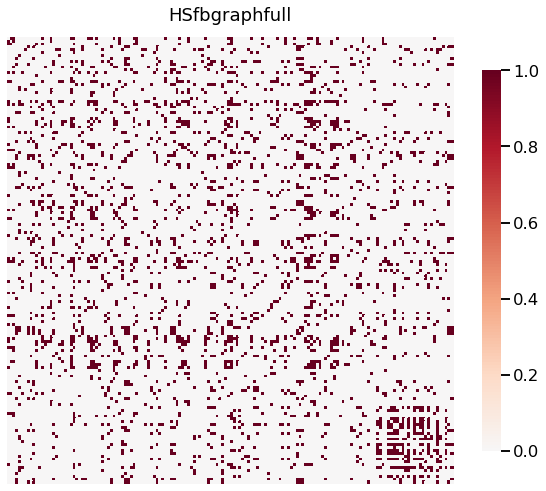

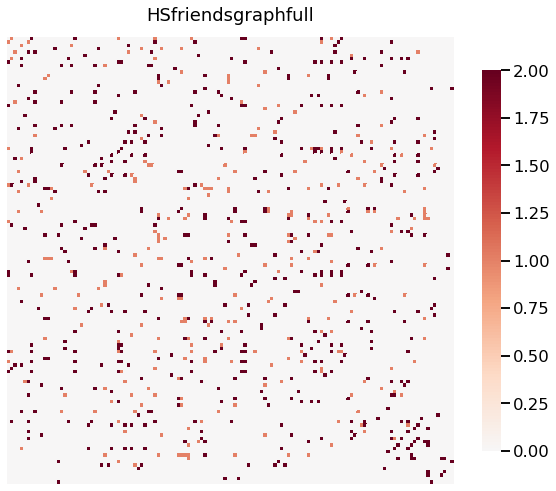

In [189]:
heatmap(adjfb, title="HSfbgraphfull")
heatmap(adjfr, title="HSfriendsgraphfull")

In [263]:
W = np.arange(coremap.shape[0]); print("len W = ", len(W))
x = 1
W = np.setdiff1d(W, [22])
S = [0, 7, 17, 24]

NBDS = vnsgm_ordered([x], S, adjfb, adjfr, h, ell, R, gamma) 

print(NBDS['corr'])

len W =  82
<class 'list'>
<class 'list'>
{1, 97, 33, 44, 55}
<class 'list'>
<class 'list'>
[0]
[0] [1] [1, 2, 131, 12, 15, 149, 22, 23, 28, 29, 31, 37, 39, 44, 45, 55, 60, 63, 69, 77, 78, 85, 89, 94, 97, 100, 105, 106, 108, 115, 124] [  2  12  15  22  23  28  29  31  37  39  44  45  55  60  63  69  77  78
  85  89  94  97 100 105 106 108 115 124 131 149]
[0] [1] [1, 97, 33, 44, 55]
[ 0  2  3 26 22  7  1 19 28 23 18 13 10 29  8 12 14 24  6  5 25 31 30 27
  9  4 17 16 15 11 21 20]


2


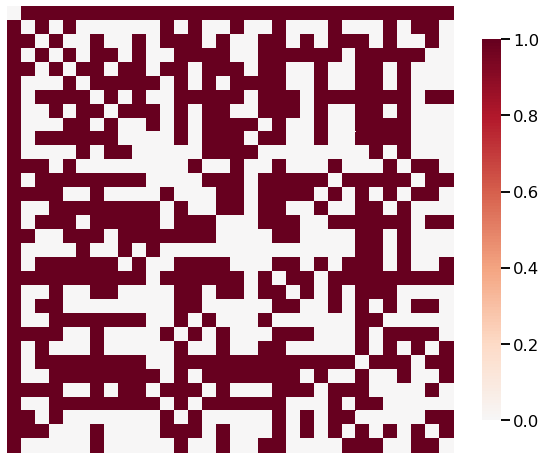

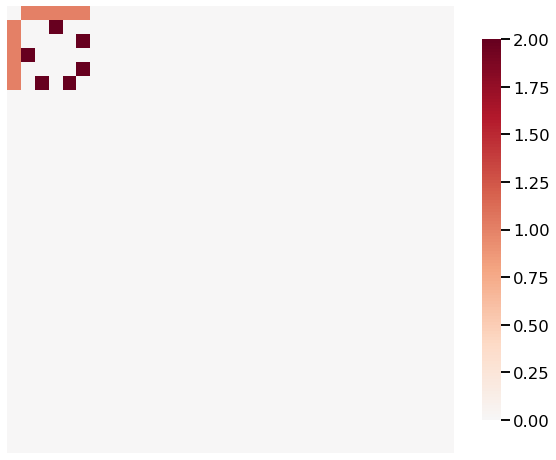

In [264]:
heatmap(NBDS['As'])
heatmap(NBDS['Bs'])
# heatmap(NBDS['As']-shuffle_adj_matrix(NBDS['Bs'], list(NBDS['corr'])))
print(NBDS['corr'][1])

In [235]:
print(NBDS['Bs'])

[[0. 1. 1. 1. 1. 1.]
 [1. 0. 0. 2. 0. 0.]
 [1. 0. 0. 0. 0. 2.]
 [1. 2. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 2.]
 [1. 0. 2. 0. 2. 0.]]


In [232]:
P = NBDS['P']
# P[np.where(P<1.8e-25)]=0
# np.transpose(P)
P

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [229]:
Cxp = NBDS['Cxp']
Cxp.sort()
print("Cxp = ", np.array(Cxp)+1)

labelsGx = NBDS['labelsGx']
labelsGx.sort()
print("labelsGx = ", np.array(labelsGx)+1)

labelsGxp = NBDS['labelsGxp']
labelsGxp.sort()
print("labelsGxp = ", np.array(labelsGxp)+1)

Cxp =  [ 2 34 45 56 98]
labelsGx =  [  1   2   3  13  16  23  24  29  30  32  38  40  45  46  56  61  64  70
  78  79  86  90  95  98 101 106 107 109 116 125 132 150]
labelsGxp =  [ 1  2 34 45 56 98]


# Figure 4 reproduction

In [4]:
hhop = 2
ell = 2
g = 0.1
R = 50
n_iter = 20
voi = 27

HSfrgraphcore = igraph.load("HSfrgraphcore.txt", format="edges")
HSfrgraphcore.to_undirected()

adj2a = np.array(HSfrgraphcore.get_adjacency().data)
print(adj2a.shape, type(adj2a))

adj2, perm2  = permute_adj_matrix(adj2a)

(82, 82) <class 'numpy.ndarray'>


In [5]:
mmp = np.transpose(np.arange(adj2.shape[0]))
mmp = np.transpose(np.stack((mmp, perm2)))

mmp2 = np.transpose(np.arange(adj2.shape[0]))
mmp2 = np.transpose(np.stack((perm2, mmp2)))

In [6]:
sp = [(ii, jj) for ii, jj in zip(perm2, list(range(adj2.shape[0])))]
sp.sort(key = lambda x: x[0])
sp = np.array(sp)

In [7]:
map2sort = mmp2[sp[:,1]]

In [8]:
P = np.diag(list(range(1, adj2.shape[0]+1)))[perm2]-1

# Reproduce figure 4

In [13]:
outdic = {'nrankxp0':[], 'nrankxpBad':[], 'imp2':[], 'potseeds':[], 
         'numcand':[], 'Nh1':[], 'Nh2':[], 'nrvois':[], 'nrvois_h1l2':[],
         'imp2_h1l2':[], 'nrvois_h2l2':[], 'imp2_h2l2':[], 'nrvois_h2l3':[], 
         'imp2_h2l3':[]}

for vvi in range(1, adj2.shape[0]+1):
    voi = vvi - 1
    
    fb_voi = map2sort[voi,0]
    fr_voi = map2sort[voi,1]
    
    Nhtmp = ego(adj2a,hhop,voi,mindist=1)
    
    
    imp2 = 0
    nrankxp0 = 0
    nrankxpBad = 0 
    
    nrvois = np.full(len(Nhtmp), None)
    
    imp2_h1l2 = 0
    nrankxp0_h1l2 = 0
    nrankxpBad_h1l2 = 0 
    
    nrvois_h1l2 = np.full(len(Nhtmp), None)
    
    
    for si, seed in enumerate(Nhtmp):
        S = map2sort[seed]
        frtmp = fr_voi + (1 if S[1]>fr_voi else 0)
        #print(S)
#         print("iter ", ii, " w shapes ", adj2a.shape, adj2.shape)
        L = vnsgm(fb_voi, S, adj2a, adj2, hhop, ell, R, g) # L <- localnbd(fb.voi,S,HSfbgraphcore,g.frscrambled,hhop,ell,R,g)
#         print(L)
        if L['case'] == 'possible':
#             print(L)
            if(frtmp in L['labelsGxp']):
                try:
                    Ps = L['P'][0:len(L['labelsGx']), 0:len(L['labelsGxp'])]
                    rankPs = pass2ranksuplus(Ps) 
                    rankvoi = rankPs[1, np.where(L['labelsGxp']==frtmp)]
                    rankvoi = (rankvoi - 1)/(len(L['Cxp'])-1)
                except:
                    rankvoi = None
                    print("error2")
            else:
                rankvoi = None
                imp2 = imp2 + 1
            
            if rankvoi is not None:
                if rankvoi == 0:
                    nrankxp0 = nrankxp0 + 1
                else:
                    if rankvoi >= 0.5:
                        nrankxpBad = nrankxpBad + 1
        else:
            rankvoi = None
            imp2 = imp2 + 1
            
        nrvois[si] = rankvoi
        
        L_h1l2 = vnsgm(fb_voi,S,adj2a,adj2,hhop,(ell+1),R,g)
        if L_h1l2['case'] == 'possible':
#             print(L)
            if(frtmp in L_h1l2['labelsGxp']):
                try:
                    Ps = L_h1l2['P'][0:len(L_h1l2['labelsGx']), 0:len(L_h1l2['labelsGxp'])]
                    rankPs_h1l2 = pass2ranksuplus(Ps) 
                    rankvoi_h1l2 = rankPs_h1l2[1, np.where(L_h1l2['labelsGxp']==frtmp)]
                    rankvoi_h1l2 = (rankvoi_h1l2 - 1)/(len(L_h1l2['Cxp'])-1)
                except:
                    print("error 4")
                    rankvoi_h1l2 = None
            else:
                rankvoi_h1l2 = None
                imp2_h1l2 = imp2_h1l2 + 1
            
            if rankvoi_h1l2 is not None:
                if rankvoi_h1l2 == 0:
                    nrankxp0_h1l2 = nrankxp0_h1l2 + 1
                else:
                    if rankvoi_h1l2 >= 0.5:
                        nrankxpBad_h1l2 = nrankxpBad_h1l2 + 1
        else:
            rankvoi_h1l2 = None
            imp2_h1l2 = imp2_h1l2 + 1
            
        nrvois_h1l2[si] = rankvoi_h1l2
                
    Nhtmp2 = ego(adj2a,hhop+1,voi,mindist=1)
    
    imp2_h2l2 = 0
    nrankxp0_h2l2 = 0
    nrankxpBad_h2l2 = 0 
    nrvois_h2l2 = np.full(len(Nhtmp2), None)
    imp2_h2l3 = 0
    nrankxp0_h2l3 = 0
    nrankxpBad_h2l3 = 0 
    nrvois_h2l3 = np.full(len(Nhtmp2), None)
    
    for si2, seed in enumerate(Nhtmp2):
        S2 = map2sort[seed]
        frtmp = fr_voi + (1 if S2[1]>fr_voi else 0)
        #print(S)
#         print("iter ", ii, " w shapes ", adj2a.shape, adj2.shape)
        L_h2l2 = vnsgm(fb_voi, S, adj2a, adj2, hhop+1, ell+1, R, g) # L <- localnbd(fb.voi,S,HSfbgraphcore,g.frscrambled,hhop,ell,R,g)
#         print(L)
        if L_h2l2['case'] == 'possible':
#             print(L)
            if(frtmp in L_h2l2['labelsGxp']):
                try:
                    Ps = L_h2l2['P'][0:len(L_h2l2['labelsGx']), 0:len(L_h2l2['labelsGxp'])]
                    rankPs_h2l2 = pass2ranksuplus(Ps) 
                    rankvoi_h2l2 = rankPs_h2l2[1, np.where(L_h2l2['labelsGxp']==frtmp)]
                    rankvoi_h2l2 = (rankvoi_h2l2 - 1)/(len(L_h2l2['Cxp'])-1)
                except:
                    print("error 3")
                    rankvoi_h2l2 = None
            else:
                rankvoi_h2l2 = None
                imp2_h2l2 = imp2_h2l2 + 1
            
            if rankvoi_h2l2 is not None:
                if rankvoi_h2l2 == 0:
                    nrankxp0_h2l2 = nrankxp0_h2l2 + 1
                else:
                    if rankvoi_h2l2 >= 0.5:
                        nrankxpBad_h2l2 = nrankxpBad_h2l2 + 1
        else:
            rankvoi_h2l2 = None
            imp2_h2l2 = imp2_h2l2 + 1
            
        nrvois_h2l2[si2] = rankvoi_h2l2
        
        L_h2l3 = vnsgm(voi,S,adj2a,adj2,hhop+1,ell+2,R,g)
        if L_h2l3['case'] == 'possible':
#             print(L)
            if(frtmp in L_h2l3['labelsGxp']):
                try:
                    Ps = L_h2l3['P'][0:len(L_h2l3['labelsGx']), 0:len(L_h2l3['labelsGxp'])]
                    rankPs_h2l3 = pass2ranksuplus(Ps) 
                    rankvoi_h2l3 = rankPs_h2l3[1, np.where(L_h2l3['labelsGxp']==frtmp)]
                    rankvoi_h2l3 = (rankvoi_h2l3 - 1)/(len(L_h2l3['Cxp'])-1)
                except:
                    rankvoi_h2l3 = None
                    print("Error")
                    print(rankPs_h2l3.shape, L_h2l3['labelsGxp'], frtmp)


            else:
                rankvoi_h2l3 = None
                imp2_h2l3 = imp2_h2l3 + 1
            
            if rankvoi_h2l3 is not None:
                if rankvoi_h2l3 == 0:
                    nrankxp0_h2l3 = nrankxp0_h2l3 + 1
                else:
                    if rankvoi_h2l3 >= 0.5:
                        nrankxpBad_h2l3 = nrankxpBad_h2l3 + 1
        else:
            rankvoi_h2l3 = None
            imp2_h2l3 = imp2_h2l3 + 1
            
        nrvois_h2l3[si2] = rankvoi_h2l3
        
    outdic['nrankxp0'].append(nrvois_h2l3)
    outdic['nrankxpBad'].append(nrankxpBad)
    outdic['imp2'].append(imp2)
    outdic['potseeds'].append(len(Nhtmp)) 
#     outdic['numcand'].append(len(L['Cxp']))
    outdic['Nh1'].append(Nhtmp)
    outdic['Nh2'].append(Nhtmp2)
    outdic['nrvois'].append(nrvois)
    outdic['nrvois_h1l2'].append(nrvois_h1l2)
    outdic['imp2_h1l2'].append(imp2_h1l2)
    outdic['nrvois_h2l2'].append(nrvois_h2l2)
    outdic['imp2_h2l2'].append(imp2_h2l2)
    outdic['nrvois_h2l3'].append(nrvois_h2l3)
    outdic['imp2_h2l3'].append(imp2_h2l3)
    

error2
error2
error2
error 4
error 4
error 4
error 3
Error
(66, 66) [17, 0, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 42, 43, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 81] 81
error 3
Error
(66, 66) [17, 0, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 42, 43, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 81] 81
error 3
Error
(66, 66) [17, 0, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 42, 43, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 81] 81
error 3
Error
(66, 66) [17, 0, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 18, 19

KeyboardInterrupt: 

In [93]:
na =  np.array(outdic['imp2_h2l2'])

In [102]:
nrvois_h2l2_nonone = []
for ii in outdic['nrvois_h2l2']:
    midres = []
    for jj in ii:
        if jj is not None:
            midres.append(jj[0][0])
    nrvois_h2l2_nonone.append(np.array(midres))
# print(nrvois_h2l2_nonone)
zero =  np.array(list(map(lambda x: len(np.where(x==0)[0]), nrvois_h2l2_nonone)))
chance =  np.array(list(map(lambda x: len(np.where(np.array(x)>0.5)[0]), nrvois_h2l2_nonone)))

In [103]:
ssizehnbdx = np.array(list(map(lambda x: len(x), outdic['nrvois_h2l2'])))


In [104]:
between = ssizehnbdx - chance - zero - na

In [105]:
print(na)
print(zero)
print(chance)
print(between)

[31  0 14 26  9 14 17  1 20  0  5 17 13  2 24 17  0  0 15  0  0  0  0  0
  0  0  0 36  0 29  0  4  0 26  0  0  0 23 17 28 32 29  2  9  1 19 47  2
  0 32  0 23 37 29 14 15 29 15  0  1 18 28  0  0  0  0 35  0 13 24  0  0
  0  6 17  0  2  0  0  0  1  1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
[ 0  1  2  0  4  0  0  0  0  1  2  0  0  0  0  0  3 11  0  1  3  0  2  3
  8  1  3  0  1  0  0  0  2  0  4  0  6  0  0  0  0  0  1  2  3  2  1  0
  0  0  3  0  0  0  0  0  0  0  4  0  2  1  7  7 10  3  0  4  4  0  2  5
 13  8  0  0  0  2  1  2  0  0]
[12 29 17  7 28  0  0  0 29 22 41  0  7  0  0  0 33 39  0 22 38 27 45 27
 42 33 50  0 46  0  0 13 41  9 47  0 23  0  0  0  0  0 25 23 32  8  3  0
  0  0 39  0  6  0  0  0  0  0 38  0 19  9 40 43 48 23  0 34 24  0 18 42
 37 39 13 29  0 31 43 41  0  0]


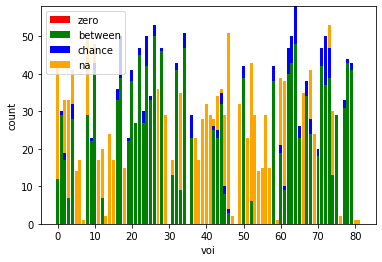

In [112]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('voi')
plt.ylabel('count')
plt.bar(np.arange(len(zero)), zero, color='r')
plt.bar(np.arange(len(between)), between, bottom=zero, color='g')
plt.bar(np.arange(len(chance)), chance, bottom=zero+between, color='b')
plt.bar(np.arange(len(na)), na, bottom=zero+between+chance, color='orange')
plt.legend(['zero', 'between', 'chance', 'na'])

# Modify Graph Match

In [11]:
import math
from scipy.optimize import linear_sum_assignment
from scipy.optimize import minimize_scalar
from sklearn.base import BaseEstimator
from sklearn.utils import check_array
from sklearn.utils import column_or_1d
from graspologic.match import SinkhornKnopp

In [252]:
class GraphMatch(BaseEstimator):
    """
    This class solves the Graph Matching Problem and the Quadratic Assignment Problem
    (QAP) through an implementation of the Fast Approximate QAP Algorithm (FAQ) (these
    two problems are the same up to a sign change) [1].

    This algorithm can be thought of as finding an alignment of the vertices of two
    graphs which minimizes the number of induced edge disagreements, or, in the case
    of weighted graphs, the sum of squared differences of edge weight disagreements.
    The option to add seeds (known vertex correspondence between some nodes) is also
    available [2].


    Parameters
    ----------

    n_init : int, positive (default = 1)
        Number of random initializations of the starting permutation matrix that
        the FAQ algorithm will undergo. n_init automatically set to 1 if
        init_method = 'barycenter'

    init_method : string (default = 'barycenter')
        The initial position chosen

        "barycenter" : the non-informative “flat doubly stochastic matrix,”
        :math:`J=1*1^T /n` , i.e the barycenter of the feasible region

        "rand" : some random point near :math:`J, (J+K)/2`, where K is some random doubly
        stochastic matrix

    max_iter : int, positive (default = 30)
        Integer specifying the max number of Franke-Wolfe iterations.
        FAQ typically converges with modest number of iterations.

    shuffle_input : bool (default = True)
        Gives users the option to shuffle the nodes of A matrix to avoid results
        from inputs that were already matched.

    eps : float (default = 0.1)
        A positive, threshold stopping criteria such that FW continues to iterate
        while Frobenius norm of :math:`(P_{i}-P_{i+1}) > eps`

    gmp : bool (default = True)
        Gives users the option to solve QAP rather than the Graph Matching Problem
        (GMP). This is accomplished through trivial negation of the objective function.

    padding : string (default = 'adopted')
        Allows user to specify padding scheme if `A` and `B` are not of equal size.
        Say that `A` and `B` have :math:`n_1` and :math:`n_2` nodes, respectively, and
        :math:`n_1 < n_2`.

        "adopted" : matches `A` to the best fitting induced subgraph of `B`. Reduces the
        affinity between isolated vertices added to `A` through padding and low-density
        subgraphs of `B`.

        "naive" : matches `A` to the best fitting subgraph of `B`.

    Attributes
    ----------

    perm_inds_ : array, size (n,) where n is the number of vertices in the fitted graphs.
        The indices of the optimal permutation (with the fixed seeds given) on the nodes of B,
        to best minimize the objective function :math:`f(P) = trace(A^T PBP^T )`.


    score_ : float
        The objective function value of for the optimal permutation found.

    n_iter_ : int
        Number of Frank-Wolfe iterations run. If `n_init` > 1, `n_iter_` reflects the number of
        iterations performed at the initialization returned.


    References
    ----------
    .. [1] J.T. Vogelstein, J.M. Conroy, V. Lyzinski, L.J. Podrazik, S.G. Kratzer,
        E.T. Harley, D.E. Fishkind, R.J. Vogelstein, and C.E. Priebe, “Fast
        approximate quadratic programming for graph matching,” PLOS one, vol. 10,
        no. 4, p. e0121002, 2015.

    .. [2] D. Fishkind, S. Adali, H. Patsolic, L. Meng, D. Singh, V. Lyzinski, C. Priebe,
        Seeded graph matching, Pattern Recognit. 87 (2019) 203–215



    """

    def __init__(
        self,
        n_init=1,
        init_method="barycenter",
        max_iter=30,
        shuffle_input=True,
        eps=0.1,
        gmp=True,
        padding="adopted",
    ):

        if type(n_init) is int and n_init > 0:
            self.n_init = n_init
        else:
            msg = '"n_init" must be a positive integer'
            raise TypeError(msg)
        if init_method == "rand":
            self.init_method = "rand"
        elif init_method == "barycenter":
            self.init_method = "barycenter"
            self.n_init = 1
        else:
            msg = 'Invalid "init_method" parameter string'
            raise ValueError(msg)
        if max_iter > 0 and type(max_iter) is int:
            self.max_iter = max_iter
        else:
            msg = '"max_iter" must be a positive integer'
            raise TypeError(msg)
        if type(shuffle_input) is bool:
            self.shuffle_input = shuffle_input
        else:
            msg = '"shuffle_input" must be a boolean'
            raise TypeError(msg)
        if eps > 0 and type(eps) is float:
            self.eps = eps
        else:
            msg = '"eps" must be a positive float'
            raise TypeError(msg)
        if type(gmp) is bool:
            self.gmp = gmp
        else:
            msg = '"gmp" must be a boolean'
            raise TypeError(msg)
        if isinstance(padding, str) and padding in {"adopted", "naive"}:
            self.padding = padding
        elif isinstance(padding, str):
            msg = 'Invalid "padding" parameter string'
            raise ValueError(msg)
        else:
            msg = '"padding" parameter must be of type string'
            raise TypeError(msg)

    def fit(self, A, B, seeds_A=[], seeds_B=[]):
        """
        Fits the model with two assigned adjacency matrices

        Parameters
        ----------
        A : 2d-array, square, positive
            A square adjacency matrix

        B : 2d-array, square, positive
            A square adjacency matrix

        seeds_A : 1d-array, shape (m , 1) where m <= number of nodes (default = [])
            An array where each entry is an index of a node in `A`.

        seeds_B : 1d-array, shape (m , 1) where m <= number of nodes (default = [])
            An array where each entry is an index of a node in `B` The elements of
            `seeds_A` and `seeds_B` are vertices which are known to be matched, that is,
            `seeds_A[i]` is matched to vertex `seeds_B[i]`.

        Returns
        -------
        self : returns an instance of self
        """
        A = check_array(A, copy=True, ensure_2d=True)
        B = check_array(B, copy=True, ensure_2d=True)
        seeds_A = column_or_1d(seeds_A)
        seeds_B = column_or_1d(seeds_B)

        # pads A and B according to section 2.5 of [2]
        if A.shape[0] != B.shape[0]:
            A, B = _adj_pad(A, B, self.padding)

        if A.shape[0] != A.shape[1] or B.shape[0] != B.shape[1]:
            msg = "Adjacency matrix entries must be square"
            raise ValueError(msg)
        elif seeds_A.shape[0] != seeds_B.shape[0]:
            msg = "Seed arrays must be of equal size"
            raise ValueError(msg)
        elif seeds_A.shape[0] > A.shape[0]:
            msg = "There cannot be more seeds than there are nodes"
            raise ValueError(msg)
        elif not (seeds_A >= 0).all() or not (seeds_B >= 0).all():
            msg = "Seed array entries must be greater than or equal to zero"
            raise ValueError(msg)
        elif (
            not (seeds_A <= (A.shape[0] - 1)).all()
            or not (seeds_B <= (A.shape[0] - 1)).all()
        ):
            msg = "Seed array entries must be less than or equal to n-1"
            raise ValueError(msg)

        n = A.shape[0]  # number of vertices in graphs
#         P_tot = np.zeros((n, n))
        
        n_seeds = seeds_A.shape[0]  # number of seeds
        n_unseed = n - n_seeds

        score = math.inf
        perm_inds = np.zeros(n)

        obj_func_scalar = 1
        if self.gmp:
            obj_func_scalar = -1
            score = 0

        seeds_B_c = np.setdiff1d(range(n), seeds_B)
        if self.shuffle_input:
            seeds_B_c = np.random.permutation(seeds_B_c)
            # shuffle_input to avoid results from inputs that were already matched

        seeds_A_c = np.setdiff1d(range(n), seeds_A)
        permutation_A = np.concatenate([seeds_A, seeds_A_c], axis=None).astype(int)
        permutation_B = np.concatenate([seeds_B, seeds_B_c], axis=None).astype(int)
        A = A[np.ix_(permutation_A, permutation_A)]
        B = B[np.ix_(permutation_B, permutation_B)]

        # definitions according to Seeded Graph Matching [2].
        A11 = A[:n_seeds, :n_seeds]
        A12 = A[:n_seeds, n_seeds:]
        A21 = A[n_seeds:, :n_seeds]
        A22 = A[n_seeds:, n_seeds:]
        B11 = B[:n_seeds, :n_seeds]
        B12 = B[:n_seeds, n_seeds:]
        B21 = B[n_seeds:, :n_seeds]
        B22 = B[n_seeds:, n_seeds:]
        A11T = np.transpose(A11)
        A12T = np.transpose(A12)
        A22T = np.transpose(A22)
        B21T = np.transpose(B21)
        B22T = np.transpose(B22)

        for i in range(self.n_init):
            # setting initialization matrix
            if self.init_method == "rand":
                sk = SinkhornKnopp()
                K = np.random.rand(
                    n_unseed, n_unseed
                )  # generate a nxn matrix where each entry is a random integer [0,1]
                for i in range(10):  # perform 10 iterations of Sinkhorn balancing
                    K = sk.fit(K)
                J = np.ones((n_unseed, n_unseed)) / float(
                    n_unseed
                )  # initialize J, a doubly stochastic barycenter
                P = (K + J) / 2
            elif self.init_method == "barycenter":
                P = np.ones((n_unseed, n_unseed)) / float(n_unseed)

            const_sum = A21 @ np.transpose(B21) + np.transpose(A12) @ B12
            grad_P = math.inf  # gradient of P
            n_iter = 0  # number of FW iterations

            # OPTIMIZATION WHILE LOOP BEGINS
            while grad_P > self.eps and n_iter < self.max_iter:

                delta_f = (
                    const_sum + A22 @ P @ B22T + A22T @ P @ B22
                )  # computing the gradient of f(P) = -tr(APB^tP^t)
                rows, cols = linear_sum_assignment(
                    obj_func_scalar * delta_f
                )  # run hungarian algorithm on gradient(f(P))
                Q = np.zeros((n_unseed, n_unseed))
                Q[rows, cols] = 1  # initialize search direction matrix Q

                def f(x):  # computing the original optimization function
                    return obj_func_scalar * (
                        np.trace(A11T @ B11)
                        + np.trace(np.transpose(x * P + (1 - x) * Q) @ A21 @ B21T)
                        + np.trace(np.transpose(x * P + (1 - x) * Q) @ A12T @ B12)
                        + np.trace(
                            A22T
                            @ (x * P + (1 - x) * Q)
                            @ B22
                            @ np.transpose(x * P + (1 - x) * Q)
                        )
                    )

                alpha = minimize_scalar(
                    f, bounds=(0, 1), method="bounded"
                ).x  # computing the step size
                P_i1 = alpha * P + (1 - alpha) * Q  # Update P
                grad_P = np.linalg.norm(P - P_i1)
                P = P_i1
                n_iter += 1
            # end of FW optimization loop

            row, col = linear_sum_assignment(
                -P
            )  # Project onto the set of permutation matrices
            perm_inds_new = np.concatenate(
                (np.arange(n_seeds), np.array([x + n_seeds for x in col]))
            )

            score_new = np.trace(
                np.transpose(A) @ B[np.ix_(perm_inds_new, perm_inds_new)]
            )  # computing objective function value
            
#             m_foo = len(seeds_A)-1
#             n_foo = n - m_foo
#             prob_mat = np.diag(np.ones((n_foo)))
#             prob_mat = np.concatenate((np.concatenate((np.diag(np.ones((m_foo))), np.zeros((m_foo, n_foo))), axis=1), np.concatenate((np.zeros((n_foo, m_foo)), prob_mat[perm_inds_new]), axis=1)), axis=0)
#             P_tot+=prob_mat

            if obj_func_scalar * score_new < obj_func_scalar * score:  # minimizing
                score = score_new
                perm_inds = np.zeros(n, dtype=int)
                perm_inds[permutation_A] = permutation_B[perm_inds_new]
                best_n_iter = n_iter

        permutation_A_unshuffle = _unshuffle(permutation_A, n)
        A = A[np.ix_(permutation_A_unshuffle, permutation_A_unshuffle)]
        permutation_B_unshuffle = _unshuffle(permutation_B, n)
        B = B[np.ix_(permutation_B_unshuffle, permutation_B_unshuffle)]
        score = np.trace(np.transpose(A) @ B[np.ix_(perm_inds, perm_inds)])

#         self.P_final = P_tot/self.n_init
        self.perm_inds_ = perm_inds  # permutation indices
        self.score_ = score  # objective function value
        self.n_iter_ = best_n_iter
        return self


    def fit_predict(self, A, B, seeds_A=[], seeds_B=[]):
        """
        Fits the model with two assigned adjacency matrices, returning optimal
        permutation indices

        Parameters
        ----------
        A : 2d-array, square, positive
            A square, positive adjacency matrix

        B : 2d-array, square, positive
            A square, positive adjacency matrix

        seeds_A : 1d-array, shape (m , 1) where m <= number of nodes (default = [])
            An array where each entry is an index of a node in `A`.

        seeds_B : 1d-array, shape (m , 1) where m <= number of nodes (default = [])
            An array where each entry is an index of a node in `B` The elements of
            `seeds_A` and `seeds_B` are vertices which are known to be matched, that is,
            `seeds_A[i]` is matched to vertex `seeds_B[i]`.

        Returns
        -------
        perm_inds_ : 1-d array, some shuffling of [0, n_vert)
            The optimal permutation indices to minimize the objective function
        """
        self.fit(A, B, seeds_A, seeds_B)
        return self.perm_inds_



def _adj_pad(A, B, method):
    def pad(X, n):
        X_pad = np.zeros((n[1], n[1]))
        X_pad[: n[0], : n[0]] = X
        return X_pad

    A_n = A.shape[0]
    B_n = B.shape[0]
    n = np.sort([A_n, B_n])
    if method == "adopted":
        A = 2 * A - np.ones((A_n, A_n))
        B = 2 * B - np.ones((B_n, B_n))

    if A.shape[0] == n[0]:
        A = pad(A, n)
    else:
        B = pad(B, n)

    return A, B


def _unshuffle(array, n):
    unshuffle = np.array(range(n))
    unshuffle[array] = np.array(range(n))
    return unshuffle

In [202]:
A = np.array([[1,2,3],[4,5,6],[7,8,9]])
A

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [203]:
A[[1, 0, 2]]

array([[4, 5, 6],
       [1, 2, 3],
       [7, 8, 9]])